In [1]:
import numpy as np
import tensorflow as tf
import pylab
%matplotlib inline

In [2]:
X_data = np.loadtxt('./coordinates2.csv', delimiter='$').astype('float64')[:,:] # Only load first 400 entries
#X_data /= np.max(X_data)    # Divide by the maximum WHY??

Y_data = np.loadtxt('./data_genotypes2.csv', delimiter='$').astype('float64')[:,:]

In [3]:
assert(len(X_data) == len(Y_data))

N = X_data.shape[0]
k = X_data.shape[1]
print("Dim. of X-data: %i x %i" % (N,k))
M1 = Y_data.shape[0]
M = Y_data.shape[1]
Y_data[Y_data < 0.5] = -1.0
print("Dim. of Y-data: %i x %i" % (M1,M))

Dim. of X-data: 441 x 2
Dim. of Y-data: 441 x 100


In [4]:
with tf.device('/cpu:0'):
    X = tf.Variable(dtype=tf.float64, initial_value=X_data, trainable=False)
    Y = tf.Variable(dtype=tf.float64, initial_value=Y_data, trainable=False)
    F = tf.Variable(dtype=tf.float64, initial_value=np.random.normal(0.0, 0.1, (N, M)).astype('float64'),
                    trainable=True)

    l = tf.placeholder(shape=[], dtype=tf.float64)
    a = tf.placeholder(shape=[], dtype=tf.float64)
    
    eye=tf.eye(N)

    K = a * tf.exp(-tf.reduce_sum(((X[:, None] - X[None, :]) ** 2) / (2 * l **2), reduction_indices=[2])) + \
        0.00001 * tf.eye(N, dtype=tf.float64) # Calculate Matrix of Covariances
    
    #K = a * tf.exp(-tf.reduce_sum(((X[:, None] - X[None, :]) ** 2) / (2 * l), reduction_indices=[2])) + \
       # 0.0001 * eye                

    p = tf.nn.sigmoid(F)            # Calculate probabilities(assuming sigmoid link function)
    Kinv_F = tf.matrix_solve(K, F)  # Calculate K^(-1)*F
    
    data_fit = -tf.reduce_sum(tf.log(1 + tf.exp(-Y * F)), reduction_indices=[0]) # Calculate Data Fit: Check  
    prior_fit = -0.5 * tf.reduce_sum(F * Kinv_F, reduction_indices=[0])          # Calcualte 1st term of prior probability: Check
    
    logL = tf.reduce_sum(data_fit + prior_fit) # Modulo terms not depending on f: Check
    
    g =  (0.5 * (Y + 1) - p) - Kinv_F # Calculate Matrix for Gradients Check
    
    W = p * (1 - p)        # Calculate first part of Hessia. It is diagonal (but here diagonal in every column)
    lhs = -K[:, :, None] * W[None, :, :] - tf.eye(N, dtype=tf.float64)[:, :, None] # Check (HEADACHE)
    #lhs = -K[:, :, None] * W[None, :, :] - eye[:, :, None] 
    rhs = tf.matmul(K, g)
    
    update = tf.matrix_solve(tf.transpose(lhs, [2, 0, 1]), tf.transpose(rhs, [1, 0])[:, :, None])[:, :, 0]
    update = tf.transpose(update)
    
    opt_op = F.assign(F - update)
    
    #####
    
    B = (W[:, None, :] ** 0.5) * K[:, :, None] * (W[None, :, :] ** 0.5) + tf.eye(N, dtype=tf.float64)[:, :, None]  # Check
    #B = (W[:, None, :] ** 0.5) * K[:, :, None] * (W[None, :, :] ** 0.5) + eye[:, :, None] 
    
    det = tf.reduce_sum(tf.log(tf.matrix_diag_part(tf.cholesky(tf.transpose(B, [2, 0, 1])))))   # Factor of 2??
    
    margL = logL - det

In [5]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.01

In [6]:
### Single Run
aa, ll = 0.1, 25

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    r = sess.run([opt_op, update, logL, margL], {a: aa, l: ll})
    print(r[-1])    # Print marginal Likelihood

-12679462.3217


In [7]:
a_list = 0.01 * 2 ** np.arange(10)   # 10
l_list = 1.0 * 2 ** np.arange(10)  # 10

print(a_list)
print(l_list)

a_list = np.logspace(-1.5, -0.5, 10)
l_list = np.logspace(1, 2, 10)
print(a_list)
print(l_list)

[ 0.01  0.02  0.04  0.08  0.16  0.32  0.64  1.28  2.56  5.12]
[   1.    2.    4.    8.   16.   32.   64.  128.  256.  512.]
[ 0.03162278  0.04084239  0.05274997  0.06812921  0.08799225  0.11364637
  0.14677993  0.18957357  0.24484367  0.31622777]
[  10.           12.91549665   16.68100537   21.5443469    27.82559402
   35.93813664   46.41588834   59.94842503   77.42636827  100.        ]


In [8]:
res = []
j=0
with tf.Session(config=config) as sess:
    for aa in a_list:
        for ll in l_list:
            print("Doing run: %i" % j)
            j+=1
    
            sess.run(tf.global_variables_initializer())   # Changed to global_variables_initializer

            prev = None
            for i in range(20):
                r = sess.run([opt_op, update, logL, margL], {a: aa, l:ll})
                if prev and np.abs(prev - r[-1]) < 0.01:
                    break
                prev = r[-1]
            print("Tested a: %4f" % aa)
            print("Tested l: %4f" % ll)
            print("Likelihood: %4f" % r[-1])
            res.append(r[-1])

Doing run: 0
Tested a: 0.031623
Tested l: 10.000000
Likelihood: -30552.353856
Doing run: 1
Tested a: 0.031623
Tested l: 12.915497
Likelihood: -30543.938202
Doing run: 2
Tested a: 0.031623
Tested l: 16.681005
Likelihood: -30533.940807
Doing run: 3
Tested a: 0.031623
Tested l: 21.544347
Likelihood: -30524.033247
Doing run: 4
Tested a: 0.031623
Tested l: 27.825594
Likelihood: -30517.247155
Doing run: 5
Tested a: 0.031623
Tested l: 35.938137
Likelihood: -30516.119180
Doing run: 6
Tested a: 0.031623
Tested l: 46.415888
Likelihood: -30521.264616
Doing run: 7
Tested a: 0.031623
Tested l: 59.948425
Likelihood: -30531.362582
Doing run: 8
Tested a: 0.031623
Tested l: 77.426368
Likelihood: -30543.843988
Doing run: 9
Tested a: 0.031623
Tested l: 100.000000
Likelihood: -30555.923464
Doing run: 10
Tested a: 0.040842
Tested l: 10.000000
Likelihood: -30548.808827
Doing run: 11
Tested a: 0.040842
Tested l: 12.915497
Likelihood: -30538.653083
Doing run: 12
Tested a: 0.040842
Tested l: 16.681005
Likeliho

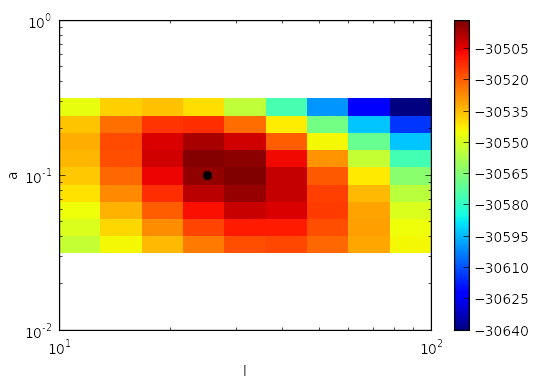

In [9]:
surface = np.array(res).reshape((10, 10))
pylab.pcolormesh(l_list, a_list, surface)
pylab.xscale('log')
pylab.yscale('log')
pylab.xlabel('l')
pylab.ylabel('a')
pylab.colorbar()
pylab.plot(25, 0.1, 'ko', linewidth=5)

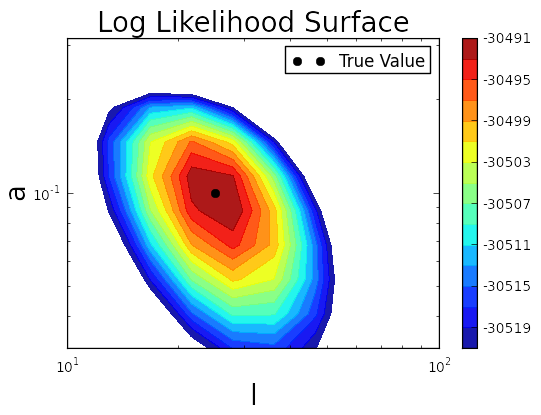

In [12]:
pylab.figure()
levels = np.arange(max(res) - 30, max(res) + 1, 2)  # Every two likelihood units
ax=pylab.contourf(l_list, a_list, surface, alpha=0.9, levels=levels)

# plt.clabel(ax, inline=1, fontsize=10)
pylab.colorbar(ax, format="%i")
pylab.title("Log Likelihood Surface", fontsize=20)
pylab.xlabel("l", fontsize=20)
pylab.ylabel("a", fontsize=20)
pylab.xscale('log')
pylab.yscale('log')
pylab.plot(25, 0.1, 'ko', linewidth=5, label="True Value")
pylab.legend()
pylab.show()

In [11]:
np.max(surface) / (N * np.log(2) * M)

-0.9975014341566667

In [20]:
with tf.Session(config=config) as sess:
    #sess.run(tf.initialize_all_variables())
    sess.run(tf.global_variables_initializer())# Update by Harald
    
    for i in range(3):
        sess.run(opt_op, {a: 0.1, l:25})
    r = sess.run(F, {a: 0.1, l: 25})
    print(r)

[[ 0.06090784 -0.05272158  0.01708335 ...,  0.05659256 -0.0747567
   0.18795428]
 [ 0.04326515 -0.08151119  0.01201972 ...,  0.08712156 -0.10628698
   0.21776664]
 [ 0.04031486 -0.07701775 -0.00603336 ...,  0.10063769 -0.13857102
   0.21582889]
 ..., 
 [ 0.17932696 -0.0008764  -0.08902204 ..., -0.10351908 -0.11762903
  -0.14271822]
 [ 0.14502793 -0.01582694 -0.1295628  ..., -0.11307538 -0.10490563
  -0.13440737]
 [ 0.08959963 -0.02304626 -0.14129821 ..., -0.10442131 -0.07741264
  -0.10911118]]


In [21]:
x, y, z = X_data[:, 0], X_data[:, 1], r[:, 1]
x=np.linspace(0, 1, 20)
print(len(x))

20


<matplotlib.colorbar.Colorbar instance at 0xbe42170>

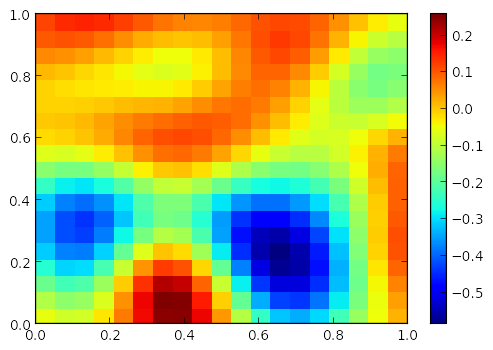

In [22]:
pylab.pcolormesh(x, x, z.reshape(21, 21))
pylab.colorbar()

In [88]:
x.shape

(20,)

In [89]:
y.shape

(400,)

In [90]:
z.shape

(400,)

In [55]:
961 ** 0.5

31.0

In [22]:
with tf.Session() as sess:
    r = sess.run(tf.diag(tf.ones(5)))

In [63]:
r

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.]], dtype=float32)

In [64]:
tf.__version__

'0.12.0-rc0'